# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

## Load sequence parameters

In [2]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_sets = f['num_sets'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]
    dTI = f['dTI'][...]
    TI0 = f['TI0'][...]
    dTE = f['dTE'][...]
    TE0 = f['TE0'][...]
    TR = f['TR'][...]

In [3]:
nUS = num_spokes
iS = matrix_size[2]//2 - 1
# iS = 0

print(f"Number of spokes: {nUS}")
print(f"Center slice number: {iS}")

Number of spokes: 64
Center slice number: 3


In [4]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_preproc_fname = os.path.join('LocalData', 'Simulations','qrage_grappa_pytorch.h5')
h5_image_fname =  os.path.join('LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [5]:
full_h5_preproc_fname = os.path.join(filepath, h5_preproc_fname)
full_h5_image_fname = os.path.join(filepath, h5_image_fname)

In [6]:
print(full_h5_preproc_fname)
print(full_h5_image_fname)

/workspaces/juart-dev/LocalData/Simulations/qrage_grappa_pytorch.h5
/workspaces/juart-dev/LocalData/Simulations/mz_me_mpnrage3d_grappa_3_64.h5


In [7]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e3 / 50

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 3 of 8.


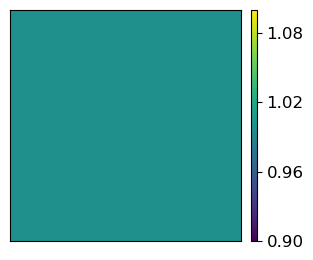

In [8]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

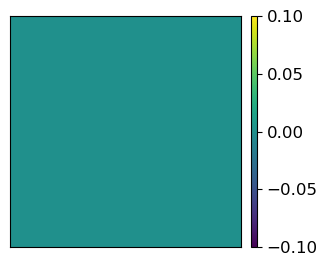

In [9]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [10]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [11]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

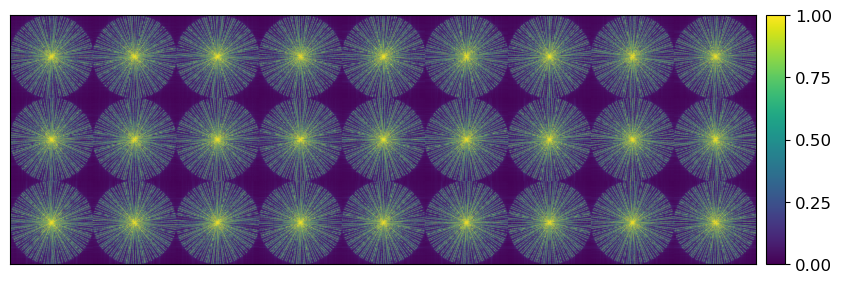

In [12]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

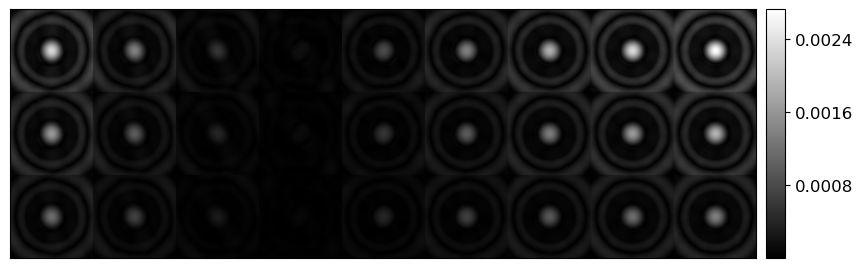

In [13]:
MultiPlotter(
    np.abs(AHd[:, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=0.0125,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

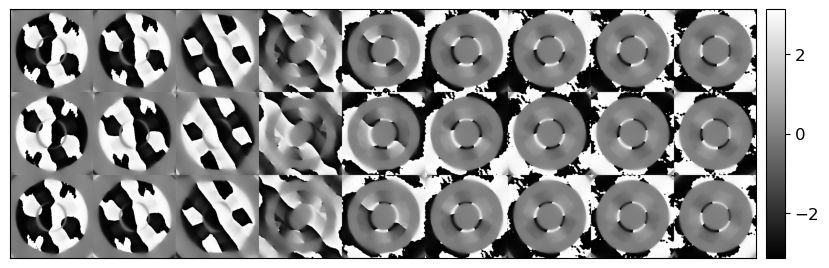

In [14]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [15]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [16]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: 3.53E-02 Dual Res: 3.53E-02 Rel Res: 1.00E+00:   3%|▎         | 1/30 [00:01<00:37,  1.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: 2.95E-02 Dual Res: 5.49E-03 Rel Res: 9.63E-01:   7%|▋         | 2/30 [00:02<00:36,  1.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.286e+00


[ADMM] Iter: 02 Prim Res: 2.04E-02 Dual Res: 1.08E-02 Rel Res: 6.92E-01:  10%|█         | 3/30 [00:03<00:34,  1.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.259e+00


[ADMM] Iter: 03 Prim Res: 1.30E-02 Dual Res: 1.15E-02 Rel Res: 3.82E-01:  13%|█▎        | 4/30 [00:05<00:32,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.246e+00


[ADMM] Iter: 04 Prim Res: 1.08E-02 Dual Res: 7.60E-03 Rel Res: 2.71E-01:  17%|█▋        | 5/30 [00:06<00:32,  1.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.329e+00


[ADMM] Iter: 05 Prim Res: 1.00E-02 Dual Res: 3.01E-03 Rel Res: 2.33E-01:  20%|██        | 6/30 [00:07<00:30,  1.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.271e+00


[ADMM] Iter: 06 Prim Res: 8.68E-03 Dual Res: 1.25E-03 Rel Res: 2.08E-01:  23%|██▎       | 7/30 [00:08<00:29,  1.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.276e+00


[ADMM] Iter: 07 Prim Res: 7.47E-03 Dual Res: 2.28E-03 Rel Res: 1.87E-01:  27%|██▋       | 8/30 [00:10<00:28,  1.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.268e+00


[ADMM] Iter: 08 Prim Res: 6.55E-03 Dual Res: 2.29E-03 Rel Res: 1.75E-01:  30%|███       | 9/30 [00:11<00:26,  1.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.303e+00


[ADMM] Iter: 09 Prim Res: 6.00E-03 Dual Res: 1.58E-03 Rel Res: 1.66E-01:  33%|███▎      | 10/30 [00:12<00:26,  1.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.338e+00


[ADMM] Iter: 10 Prim Res: 5.51E-03 Dual Res: 8.32E-04 Rel Res: 1.55E-01:  37%|███▋      | 11/30 [00:14<00:24,  1.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.299e+00


[ADMM] Iter: 11 Prim Res: 4.97E-03 Dual Res: 6.09E-04 Rel Res: 1.41E-01:  40%|████      | 12/30 [00:15<00:23,  1.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.269e+00


[ADMM] Iter: 12 Prim Res: 4.50E-03 Dual Res: 6.73E-04 Rel Res: 1.27E-01:  43%|████▎     | 13/30 [00:16<00:21,  1.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.270e+00


[ADMM] Iter: 13 Prim Res: 4.15E-03 Dual Res: 5.60E-04 Rel Res: 1.17E-01:  47%|████▋     | 14/30 [00:17<00:20,  1.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.256e+00


[ADMM] Iter: 14 Prim Res: 3.90E-03 Dual Res: 4.02E-04 Rel Res: 1.09E-01:  50%|█████     | 15/30 [00:19<00:19,  1.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.265e+00


[ADMM] Iter: 15 Prim Res: 3.69E-03 Dual Res: 2.82E-04 Rel Res: 1.04E-01:  53%|█████▎    | 16/30 [00:20<00:18,  1.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.334e+00


[ADMM] Iter: 16 Prim Res: 3.52E-03 Dual Res: 2.72E-04 Rel Res: 9.91E-02:  57%|█████▋    | 17/30 [00:21<00:17,  1.31s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.361e+00


[ADMM] Iter: 17 Prim Res: 3.38E-03 Dual Res: 2.70E-04 Rel Res: 9.56E-02:  60%|██████    | 18/30 [00:23<00:15,  1.32s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.337e+00


[ADMM] Iter: 18 Prim Res: 3.22E-03 Dual Res: 2.82E-04 Rel Res: 9.16E-02:  63%|██████▎   | 19/30 [00:24<00:14,  1.34s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.371e+00


[ADMM] Iter: 19 Prim Res: 3.03E-03 Dual Res: 2.87E-04 Rel Res: 8.65E-02:  67%|██████▋   | 20/30 [00:25<00:13,  1.32s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.277e+00


[ADMM] Iter: 20 Prim Res: 2.83E-03 Dual Res: 2.99E-04 Rel Res: 8.09E-02:  70%|███████   | 21/30 [00:27<00:11,  1.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.261e+00


[ADMM] Iter: 21 Prim Res: 2.65E-03 Dual Res: 2.71E-04 Rel Res: 7.58E-02:  73%|███████▎  | 22/30 [00:28<00:10,  1.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.299e+00


[ADMM] Iter: 22 Prim Res: 2.49E-03 Dual Res: 2.30E-04 Rel Res: 7.15E-02:  77%|███████▋  | 23/30 [00:29<00:09,  1.35s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.464e+00


[ADMM] Iter: 23 Prim Res: 2.37E-03 Dual Res: 1.81E-04 Rel Res: 6.80E-02:  80%|████████  | 24/30 [00:31<00:08,  1.37s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.432e+00


[ADMM] Iter: 24 Prim Res: 2.26E-03 Dual Res: 1.43E-04 Rel Res: 6.49E-02:  83%|████████▎ | 25/30 [00:32<00:06,  1.36s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.325e+00


[ADMM] Iter: 25 Prim Res: 2.17E-03 Dual Res: 1.19E-04 Rel Res: 6.23E-02:  87%|████████▋ | 26/30 [00:33<00:05,  1.34s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.303e+00


[ADMM] Iter: 26 Prim Res: 2.09E-03 Dual Res: 1.06E-04 Rel Res: 5.99E-02:  90%|█████████ | 27/30 [00:35<00:03,  1.33s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.305e+00


[ADMM] Iter: 27 Prim Res: 2.00E-03 Dual Res: 1.03E-04 Rel Res: 5.75E-02:  93%|█████████▎| 28/30 [00:36<00:02,  1.33s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.321e+00


[ADMM] Iter: 28 Prim Res: 1.92E-03 Dual Res: 1.02E-04 Rel Res: 5.52E-02:  97%|█████████▋| 29/30 [00:37<00:01,  1.32s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.283e+00


[ADMM] Iter: 29 Prim Res: 1.85E-03 Dual Res: 9.49E-05 Rel Res: 5.34E-02: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.250e+00


tensor([-2.5768e-07,  1.4539e-07, -1.7267e-07,  ..., -1.0097e-07,
         2.7554e-07,  9.3832e-08])

In [17]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_7365/2121847719.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


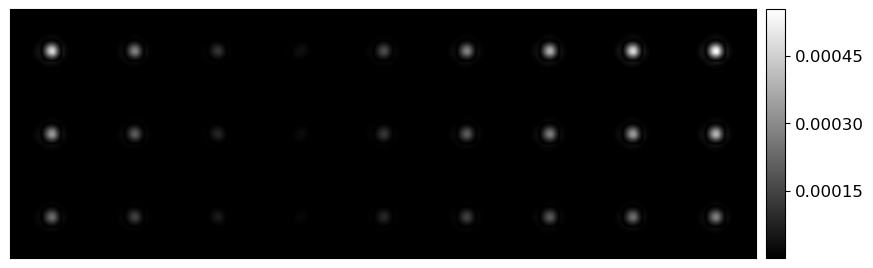

In [18]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=20,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [19]:
with h5py.File(full_h5_image_fname, "w", libver='latest') as h5_preproc_file:
    dset = h5_preproc_file.create_dataset("x", data=z_image, chunks=(nX, nY, nZ, 1, 1, 1))

In [ ]:
# plt.savefig(os.path.join(filepath, 'reconstruction_MR0.png'), dpi=1200, transparent=True)